In [1]:
import pylab as plt
import multiprocessing as mp
from train import train, epochs

c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ligua\appd






iter 100: train accuracy 0.860215
iter 100: test accuracy 0.772727
iter 200: train accuracy 0.90121
iter 200: test accuracy 0.782132
iter 300: train accuracy 0.907258
iter 300: test accuracy 0.789969
iter 400: train accuracy 0.909274
iter 400: test accuracy 0.778997
iter 500: train accuracy 0.908602
iter 500: test accuracy 0.775862
iter 600: train accuracy 0.909946
iter 600: test accuracy 0.775862
iter 700: train accuracy 0.910618
iter 700: test accuracy 0.778997
iter 800: train accuracy 0.909274
iter 800: test accuracy 0.783699
iter 900: train accuracy 0.911962
iter 900: test accuracy 0.783699
iter 1000: train accuracy 0.913979
iter 1000: test accuracy 0.782132
iter 1100: train accuracy 0.913306
iter 1100: test accuracy 0.788401
iter 1200: train accuracy 0.915323
iter 1200: test accuracy 0.791536
iter 1300: train accuracy 0.916667
iter 1300: test accuracy 0.789969
iter 1400: train accuracy 0.918683
iter 1400: test accuracy 0.789969
iter 1500: train accuracy 0.920699
iter 1500: te

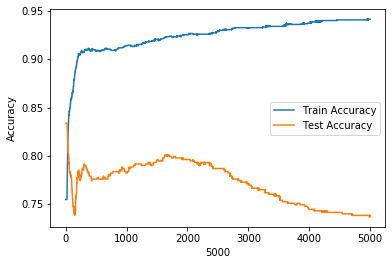

In [2]:
def main():
    params = []
    param = {}
    param['weight_decay_parameter'] = 0.000001
    param['batch_size'] = 32
    param['hidden_layer_neuron_num'] = 10
    params.append(param)
    
    accs = []
    for param in params:
        acc = train(param)
        accs.append(acc)
        
    plt.figure()
    for i in range(len(params)):
        plt.plot(range(epochs), accs[i][0], label='Train Accuracy')
        plt.plot(range(epochs), accs[i][1], label='Test Accuracy')
        
    plt.xlabel(str(epochs))
    plt.ylabel('Accuracy')
    plt.legend()
    plt

if __name__ == '__main__':
    main()